<a href="https://colab.research.google.com/github/Vitomir84/Random-forest-model-of-predicting-long-term-poverty/blob/master/RF%20model%20of%20predicting%20longterm%20poverty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Random forest prediktivni model dugorocnog siromastva u Srbiji.**
Ovo je jedna brza i "prljava" analiza uradjena za samo jedan dan bez većeg udubljivanja u podatke (!). 

Random forest algoritam se ne koristi u društvenim naukama barem u Srbiji još uvek koliko mi je poznato i zato sam samo zeleo da ovde na brzinu pokažem šta znam i kako se model moze dalje optimizovati.
Na kraju je prikazana brza analiza greske u klasifikaciji u zavisnosti od broja izvucenih drveća ali se to moze lako uraditi i za ostale parametre kao sto su broj cvorova ili broj prediktora koje ce rf uzimati prilikom svakog racvanja. Dalje unapredjenje modela bi bilo koriscenje XGBoost algoritma koji ima stopu ucenja nadovezujuci se na prethodno izvucena drveca.

**O samim podacima i sadržaju analize:**

Osnovni cilj ove analize jeste da predvidi dugoročno siromaštvo. Radi se o zvaničnim državnim podacima ali u ovoj analizi se ne prikazuju nikakvi lični ili drugi agregirani podaci, a baza je resamplovana tako da se iz nje ne može ništa zaključiti (što je u skladu sa ugovorom koji sam potpisao). Varijabla dugoročnog siromaštva je na nivou Eurostat-a definisana tako da su dugoročno siromašni oni ispitanici koji su pod rizikom od siromaštva (60% medijane prihoda) u dve od poslednje tri godine. Koristiće se Random forest model. 
Prediktori su:

OVERCROWDED	Smatra se da osoba živi u prenaseljenom domaćinstvu ako domaćinstvo nema na raspolaganju minimalni broj soba koji je jednak: 
jedna soba po paru u domaćinstvu;
jedna soba za svaku osobu staru 18 i više godina;
jedna soba za par osoba istog pola između 12 i 17 godina; jedna soba za svaku pojedinu osobu između 12 i 17 različitog pola; jedna soba po paru dece mlađih od 12 godina.	Kategorička (binarna)	1 – Prisutna prenaseljenost u domaćinstvu; 0 – nema prenaseljenosti

LOW_WORK_INTENSITY	Osoba živi u domaćinstvu gde su ukućani starosti 0-59 godina radili manje od 20%
njihovog ukupnog radnog potencijala tokom prošle godine.	Kategorička (binarna)	1 – osoba živi u domaćinstvu sa niskim intenzitetom rada; 0 – osoba ne živi u takvom domaćinstvu
POL	Pol ispitanika	Transformisana , Kategorička (binarna) 	0 – muško, 1 - žensko

ZDRAVLJE	Samoprocena zdravstvenog stanja ispitanika	Transformisana, Kategorička (binarna) 	1-Loše zdravstveno stanje, 0-dobro zdravstveno stanje

UDOVIŠTVO	 Izgubljen partner	Transformisana, Kategorička (binarna) 	1-osoba je udovac/udovica, 0-osoba nije udovac/udovica

DROPOUT	Osoba je napustila osnovnu školu ili srednju školu.	Transformisana, Kategorička (binarna) 	1-osoba je napustila osnovnu ili srednju školu, 0 – osoba ima završenu srednju školi ili viši nivo obrazovanja
ZDRAV_SPREČENOST_ZA_AKTIVNOSTI	Sprečenost za aktivnosti usled zdravstvenog stanja	Transformisana, Kategorička (binarna) 	1 – osoba je limitirana u aktivnostima usled zdravstvenog stanja, 0 – osoba nije limitirana u aktivnostima

IKADA_RADIO_LA	Osoba je nekada bila u radnom odnosu.	Transformisana, Kategorička (binarna) 	1 – osoba nikada nije bila u radnom odnosu, 0 – osoba je bila u radnom odnosu ili je sada zaposlena

SPOSOBNOST_ZA_RAD	Osoba je radno sposobna.	Transformisana, Kategorička (binarna) 	1 – osoba nije sposobna za rad, 0 – osoba je sposobna za rad ili radi

NEZAPOSLENOST	Osoba je radila makar 1h tokom prošle nedelje.	Transformisana, Kategorička (binarna) 	1 – osoba nije radila ni jedan sat prošle nedelje, 0 – osoba je radila makar jedan sat prošle nedelje

SAMOZAPOSLENOST_PORODIČNI_RAD	Osoba je samozaposlena bez zaposlenih ili radi u okviru porodičnog biznisa	Transformisana, Kategorička (binarna) 	1 – osoba je samozaposlena ili radi u okviru porodičnog biznisa, 0 – osoba ima drugu vrstu zaposlenja

PRIHOD_OD_RADA_U_NATURI	Procenjeni iznos u novcu koji domaćinstvo ima a da dolazi u vidu roba ili drugih izvora (npr. poljoprivredni proizvodi)	Standardizovana kvantitativna varijabla 	

PORODICE_SA_TROJE_I_VIŠE_DECE	Porodica ima troje ili više zavisne dece.	Transformisana, Kategorička (binarna) 	1 – domaćinstvo sa troje ili više zavisne dece, 0 – druga vrsta domaćinstva


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Uzimamo bazu podataka. Baza je bez imena i bilo kakvih identifikatora. Baza je resemplovana tako da se radi sa simuliranim podacima kako bi se isprobao model. 

In [0]:
from google.colab import files
uploaded = files.upload()


Saving silc_r.sav to silc_r.sav


Instaliramo paket za ucitavanje spss fajlova. Moramo u panda paketu definisati sta su imena kolona, odnosno varijabli. Baza je ucitana i trazimo da nam da ispis za prvih nekoliko redova.

In [0]:
!pip install -q savReaderWriter
import pandas
import savReaderWriter

with savReaderWriter.SavReader('silc_r.sav', ioUtf8 = True) as reader:
    df = pandas.DataFrame(reader.all(), columns = ['TENSTA', 'OVERCROWDED', 'NDCH', 'ZWORKINT', 'ZINCPEN', 'LOWWORKINT2016', 'SEVDEP2015', 'LOWWORKINT2015', 'LONGPOV', 'POL', 'ZDRAVLJE', 'UDOVISTVO', 'ZDRAVSPRE?ENOSTZAAKTIVNOSTI', 'NEZAPOSLENOST', 'SAMOZAPOSLENOSTPORODIcNI_RAD', 'NATURA', 'DROPOUT'])
df.head()

     |████████████████████████████████| 50.9MB 80kB/s 


,TENSTA,OVERCROWDED,NDCH,ZWORKINT,ZINCPEN,LOWWORKINT2016,SEVDEP2015,LOWWORKINT2015,LONGPOV,POL,ZDRAVLJE,UDOVISTVO,ZDRAVSPRE?ENOSTZAAKTIVNOSTI,NEZAPOSLENOST,SAMOZAPOSLENOSTPORODIcNI_RAD,NATURA,DROPOUT
0,1.0,0.0,0.0,1.578203,1.447013,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,-0.049671,0.0
1,1.0,0.0,0.0,1.578203,-0.448822,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,-0.049671,0.0
2,1.0,0.0,2.0,-0.623059,-0.448822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.049671,0.0
3,1.0,0.0,2.0,-0.623059,-0.448822,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.049671,0.0
4,1.0,0.0,2.0,-0.623059,-0.448822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.049671,0.0


Trazimo da vidimo strukturu varijabli, da li odgovara osobinama varijabli.

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16659 entries, 0 to 16658
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   TENSTA                        16659 non-null  float64
 1   OVERCROWDED                   16659 non-null  float64
 2   NDCH                          16659 non-null  float64
 3   ZWORKINT                      16659 non-null  float64
 4   ZINCPEN                       14155 non-null  float64
 5   LOWWORKINT2016                12238 non-null  float64
 6   SEVDEP2015                    7837 non-null   float64
 7   LOWWORKINT2015                7837 non-null   float64
 8   LONGPOV                       7837 non-null   float64
 9   POL                           14155 non-null  float64
 10  ZDRAVLJE                      14155 non-null  float64
 11  UDOVISTVO                     14155 non-null  float64
 12  ZDRAVSPRE?ENOSTZAAKTIVNOSTI   14155 non-null  float64
 13  N

Ispitujemo neke glavne osobine varijabli.

In [0]:
df.describe()

,TENSTA,OVERCROWDED,NDCH,ZWORKINT,ZINCPEN,LOWWORKINT2016,SEVDEP2015,LOWWORKINT2015,LONGPOV,POL,ZDRAVLJE,UDOVISTVO,ZDRAVSPRE?ENOSTZAAKTIVNOSTI,NEZAPOSLENOST,SAMOZAPOSLENOSTPORODIcNI_RAD,NATURA,DROPOUT
count,16659.000000,16659.000000,16659.000000,1.665900e+04,1.415500e+04,12238.000000,7837.000000,7837.000000,7837.000000,14155.000000,14155.000000,14155.000000,14155.000000,14155.000000,16659.000000,1.415500e+04,16659.000000
mean,1.024911,0.575725,1.121736,-2.011344e-15,-2.662582e-15,0.165387,0.236315,0.166901,0.292076,0.515789,0.205510,0.126881,0.191593,0.608690,0.067531,1.520006e-15,0.272345
std,0.155860,0.494247,1.210946,1.000000e+00,1.000000e+00,0.371544,0.424845,0.372911,0.454746,0.499768,0.404088,0.332851,0.393568,0.488061,0.250947,1.000000e+00,0.445180
min,1.000000,0.000000,0.000000,-6.455213e-01,-4.488215e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.967128e-02,0.000000
25%,1.000000,0.000000,0.000000,-6.366301e-01,-4.488215e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.967128e-02,0.000000
50%,1.000000,1.000000,1.000000,-6.286749e-01,-4.488215e-01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-4.967128e-02,0.000000
75%,1.000000,1.000000,2.000000,1.578203e+00,-4.488215e-01,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-4.967128e-02,1.000000
max,2.000000,1.000000,9.000000,1.578203e+00,2.545586e+01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.623186e+01,1.000000


Isprobavamo jos neke razlicite stvari za najvaznije varijable.

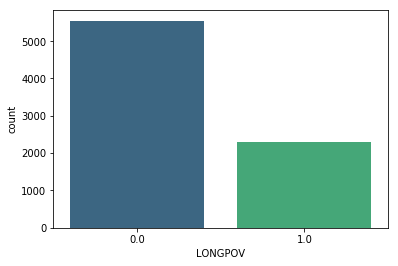

In [0]:
sns.countplot(x='LONGPOV',data=df,palette='viridis')

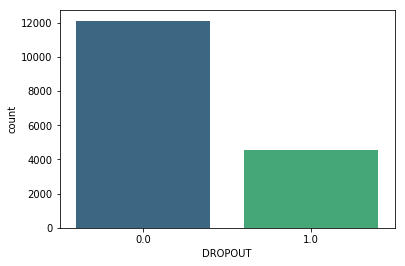

In [0]:
sns.countplot(x='DROPOUT',data=df,palette='viridis')

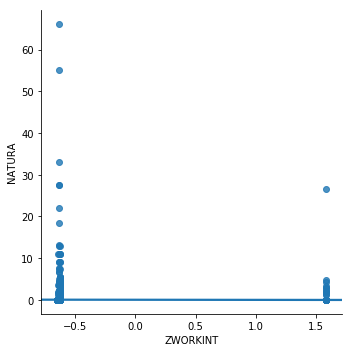

In [0]:
sns.lmplot(x='ZWORKINT',y='NATURA',data=df)

Ovako ne moze. Zaboravili smo da kategoricke varijable kreiramo da zaista i budu kategoricke.

In [0]:
df['OVERCROWDED'] = pd.Categorical(df.OVERCROWDED)
df['LOWWORKINT2016'] = pd.Categorical(df.LOWWORKINT2016)
df['SEVDEP2015'] = pd.Categorical(df.SEVDEP2015)
df['LOWWORKINT2015'] = pd.Categorical(df.LOWWORKINT2015)
df['POL'] = pd.Categorical(df.POL)
df['LONGPOV'] = pd.Categorical(df.LONGPOV)
df['ZDRAVLJE'] = pd.Categorical(df.ZDRAVLJE)
df['UDOVISTVO'] = pd.Categorical(df.UDOVISTVO)
df['NEZAPOSLENOST'] = pd.Categorical(df.NEZAPOSLENOST)
df['SAMOZAPOSLENOSTPORODIcNI_RAD'] = pd.Categorical(df.SAMOZAPOSLENOSTPORODIcNI_RAD)
df['DROPOUT'] = pd.Categorical(df.DROPOUT)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16659 entries, 0 to 16658
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   TENSTA                        16659 non-null  float64 
 1   OVERCROWDED                   16659 non-null  category
 2   NDCH                          16659 non-null  float64 
 3   ZWORKINT                      16659 non-null  float64 
 4   ZINCPEN                       14155 non-null  float64 
 5   LOWWORKINT2016                12238 non-null  category
 6   SEVDEP2015                    7837 non-null   category
 7   LOWWORKINT2015                7837 non-null   category
 8   LONGPOV                       7837 non-null   category
 9   POL                           14155 non-null  category
 10  ZDRAVLJE                      14155 non-null  category
 11  UDOVISTVO                     14155 non-null  category
 12  ZDRAVSPRE?ENOSTZAAKTIVNOSTI   14155 non-null  

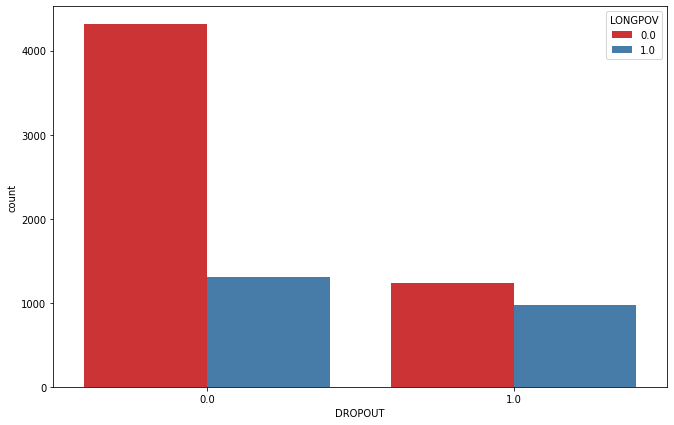

In [0]:
plt.figure(figsize=(11,7))
sns.countplot(x='DROPOUT',hue='LONGPOV',data=df,palette='Set1')

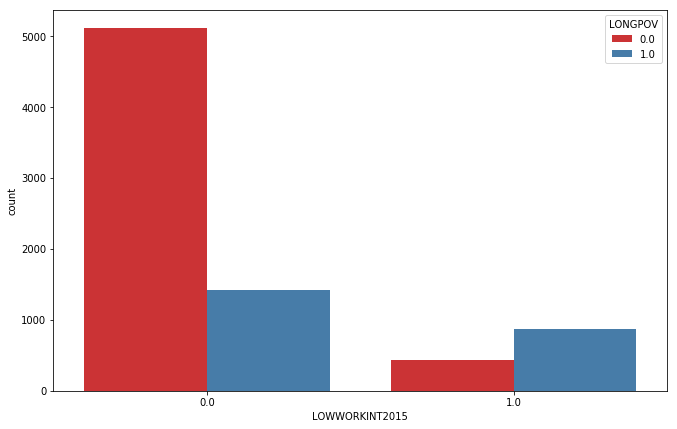

In [0]:
plt.figure(figsize=(11,7))
sns.countplot(x='LOWWORKINT2015',hue='LONGPOV',data=df,palette='Set1')

KeyboardInterrupt: ignored

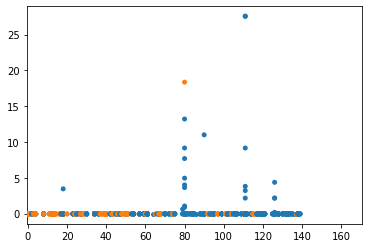

In [0]:
sns.swarmplot(x="ZWORKINT", y="NATURA", hue="LONGPOV", data=df)

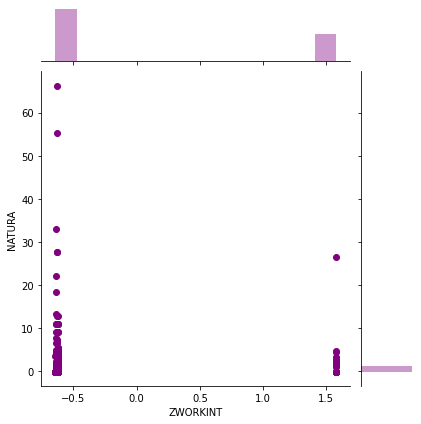

In [0]:
sns.jointplot(x='ZWORKINT',y='NATURA',data=df,color='purple')

Kreiramo trening dataset i test data set kako bismo prediktovali vrednosti na osnovu random forest algoritma.

In [0]:
from sklearn.model_selection import train_test_split
X = df.drop('LONGPOV',axis=1)
y = df['LONGPOV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

Prvo pravimo jedno drvo odlucivanja (desicion tree)

In [0]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
dtree.fit(X_train,y_train)

ValueError: ignored

Model ne radi jer nailazi na nedostajuce vrednosti. Moramo da ih izbacimo.

In [0]:
df1 = df.dropna()
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6820 entries, 0 to 8322
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   TENSTA                        6820 non-null   float64 
 1   OVERCROWDED                   6820 non-null   category
 2   NDCH                          6820 non-null   float64 
 3   ZWORKINT                      6820 non-null   float64 
 4   ZINCPEN                       6820 non-null   float64 
 5   LOWWORKINT2016                6820 non-null   category
 6   SEVDEP2015                    6820 non-null   category
 7   LOWWORKINT2015                6820 non-null   category
 8   LONGPOV                       6820 non-null   category
 9   POL                           6820 non-null   category
 10  ZDRAVLJE                      6820 non-null   category
 11  UDOVISTVO                     6820 non-null   category
 12  ZDRAVSPRE?ENOSTZAAKTIVNOSTI   6820 non-null   fl

Ponavljamo sada kod.

In [0]:
from sklearn.model_selection import train_test_split
X = df1.drop('LONGPOV',axis=1)
y = df1['LONGPOV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [0]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
dtree.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:319: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter.
  FutureWarning)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [0]:
Kreiramo sada varijablu sa predikcijama na osnovu desicion tree modela i onda je ukrstamo sa stvarnim vrednostima da bismo dobili tacnost predikcija.

In [0]:
predictions = dtree.predict(X_test)

In [0]:
from sklearn.metrics import classification_report,confusion_matrix

In [0]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.85      0.88      0.86      1480
         1.0       0.65      0.58      0.61       566

    accuracy                           0.80      2046
   macro avg       0.75      0.73      0.74      2046
weighted avg       0.79      0.80      0.79      2046



Nije nesto. Random forest ce ga znatno poboljsati.

In [0]:
print(confusion_matrix(y_test,predictions))

[[1298  182]
 [ 235  331]]


80% accuracy rate u predvidjanjima. Stvarno nije nesto. Idemo u sumu.

In [0]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=600)
rfc.fit(X_train,y_train)
predictions = rfc.predict(X_test)

from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88      1480
         1.0       0.70      0.63      0.66       566

    accuracy                           0.82      2046
   macro avg       0.78      0.76      0.77      2046
weighted avg       0.82      0.82      0.82      2046

[[1325  155]
 [ 211  355]]


Opet nije nesto. U R sam dobio 90% sto znaci da sam ovde ucitao najverovatnije bazu sa manjim brojem prediktora ili da u sintaksi nisam kategorisao sve varijable kao kategoricke.

Treba i odstampati ovo drvece kako bi videli sta su nam vazni prediktori i kako bi model dobio neki smisao.

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


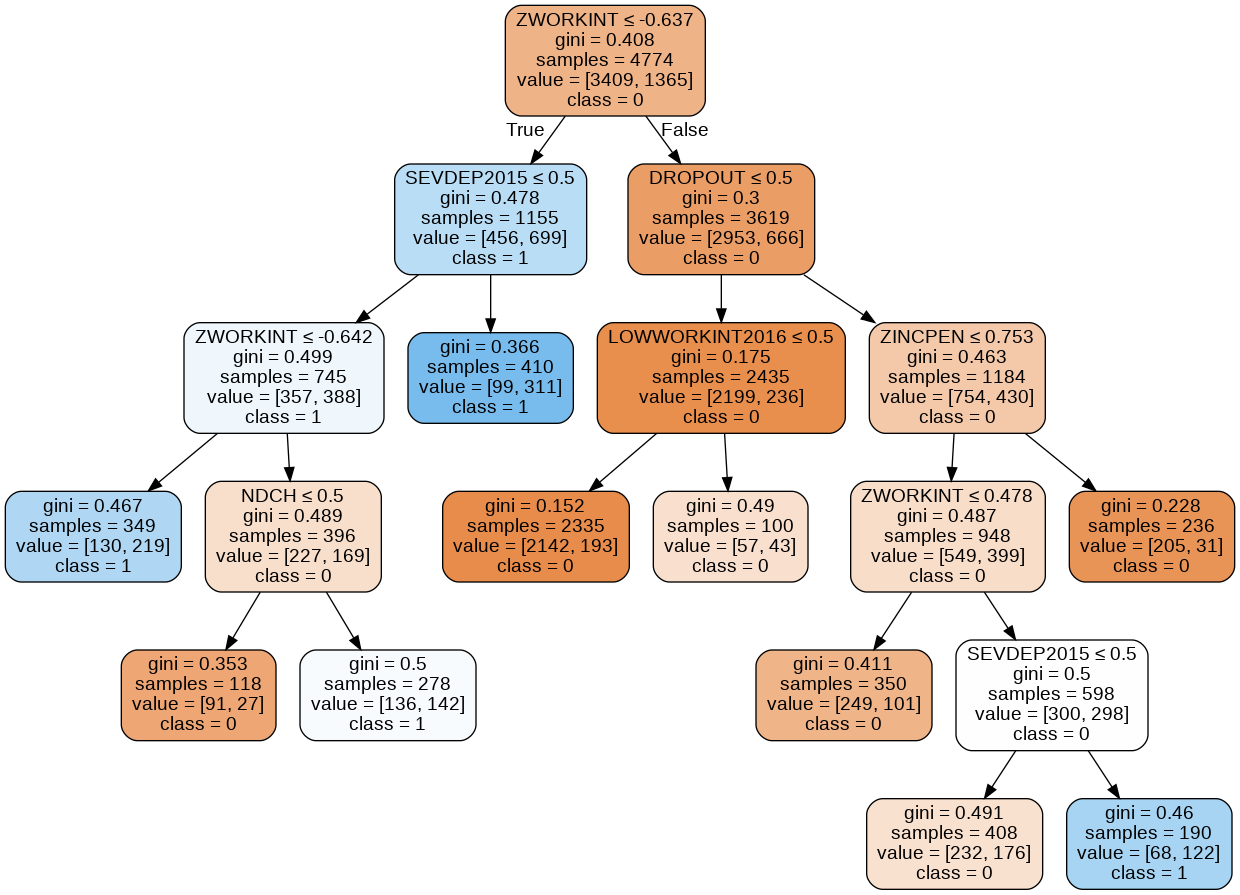

In [0]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

colnames= ['TENSTA',	'OVERCROWDED',	'NDCH',	'ZWORKINT',	'ZINCPEN',	'LOWWORKINT2016',	'SEVDEP2015',	'LOWWORKINT2015', 'LONGPOV',	'POL',	'ZDRAVLJE',	'UDOVISTVO',	'ZDRAVSPRE?ENOSTZAAKTIVNOSTI',	'NEZAPOSLENOST',	'SAMOZAPOSLENOSTPORODIcNI_RAD	NATURA',	'DROPOUT']

dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = colnames,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Moramo da vidimo koji prediktori u najvecoj meri doprinose predvidjanju dugorocnog siromastva.

In [0]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,

In [0]:
sel.get_support()

array([False, False,  True,  True,  True,  True, False,  True, False,
       False, False, False, False, False, False,  True])

In [0]:
selected_feat= X_train.columns[(sel.get_support())]
len(selected_feat)

6

In [0]:
print(selected_feat)

Index(['NDCH', 'ZWORKINT', 'ZINCPEN', 'LOWWORKINT2016', 'LOWWORKINT2015',
       'DROPOUT'],
      dtype='object')


To je broj dece, nizak intenzitet rada, niski prihodi od penzija i napustena skola.

Sada cemo kao zacin za kraj videti kako se klasifikaiona greska smanjuje u zavisnosti od broja izvucenih drveca. U radu sa velikim podacima pravilno optimizovanje, odnosno gledanje preseka 
najmanjeg broja drveca i najmanje greske dobijamo model za koji ne treba puno vremena da bude uradjen. Jos vaznije je optimizovanje koje sprecava overfitovanje, odnosno trazi najbolji odnos varijanse i pristrasnosti u modelu a to se moze raditi po slicnom principu tako sto ce se "i" uzeti kao broj cvorova (max_leaf_nodes) ili broj prediktora (max_features) ( koji se uzimaju u racvanju i pratiti se greska predvidjanja u odnosu na te parametre. Ali o tome nekom drugom prilikom ili na intervjuu za posao. 

In [0]:
stopa_greske=[]

for i in range(1,100):
    rf = RandomForestClassifier(n_estimators=i)
    rf.fit(X_train,y_train)
    predictions = rf.predict(X_test)
    stopa_greske.append(np.mean(predictions!=y_test))

Text(0.5, 1.0, 'Stopa greske vs Broj izvucenih drveca')

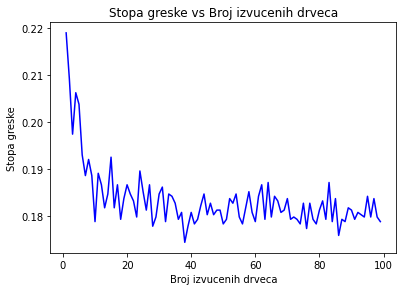

In [0]:
fig = plt.figure()

# dodajemo axes u figuri
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # velicina osa
x=range(1,100)
# plotujemo ose
axes.plot(x, stopa_greske, 'b')
axes.set_xlabel('Broj izvucenih drveca') # Notice the use of set_ to begin methods
axes.set_ylabel('Stopa greske')
axes.set_title('Stopa greske vs Broj izvucenih drveca')